# Carga datos places desde el bucket de AWS

In [1]:
"""   Librerías   """
import pandas as pd # Manipulación y EDA
import numpy as np # Manipulación y EDA
import matplotlib.pyplot as plt # Gráficos
import seaborn as sns # Gráficos
from dataAccess import aws_df_from_S3_csv # AWS

In [3]:
df_places = aws_df_from_S3_csv("Arnau/places_imputed.csv")
df_places = df_places.drop(['Unnamed: 0'], axis = 1)
df_places.head()

,place_id,name,business_status,rating,user_ratings_total,scope,types,find_type,lat,lon,price_level_missing,price_level
0,ChIJFxKKG7wnQg0RNYE_E60EZ7g,La Madreña Santa Lucrecia,OPERATIONAL,3.8,1348,GOOGLE,"['restaurant', 'food', 'point_of_interest', 'e...",restaurant,40.386727,-3.718799,0,2.0
1,ChIJo3OI7JYnQg0RGV2mWtE-9v8,Restaurante World,OPERATIONAL,4.0,220,GOOGLE,"['restaurant', 'food', 'point_of_interest', 'e...",restaurant,40.385361,-3.726651,0,1.0
2,ChIJwXyYMZEnQg0Rb9hEHqaxtO8,Bar Alfonsillo,OPERATIONAL,4.5,402,GOOGLE,"['cafe', 'bar', 'restaurant', 'food', 'point_o...",restaurant,40.384738,-3.728618,0,1.0
3,ChIJbYvKyL0nQg0R981bqgVos40,Mesón A Casiña,OPERATIONAL,4.4,333,GOOGLE,"['restaurant', 'cafe', 'bar', 'food', 'point_o...",restaurant,40.385918,-3.721233,0,1.0
4,ChIJvz9205AnQg0RC21REfqPWeU,Doner Kebab Lima,OPERATIONAL,3.3,13,GOOGLE,"['meal_delivery', 'restaurant', 'food', 'point...",restaurant,40.383741,-3.728431,1,1.0


# EDA

In [4]:
# Número de registros que contiene el dataset
print("El dataset contiene un total de {} establecimientos.\n".format(len(df_places)))

El dataset contiene un total de 10614 establecimientos.



In [5]:
df_places.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10614 entries, 0 to 10613
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   place_id             10614 non-null  object 
 1   name                 10614 non-null  object 
 2   business_status      10614 non-null  object 
 3   rating               10614 non-null  float64
 4   user_ratings_total   10614 non-null  int64  
 5   scope                10614 non-null  object 
 6   types                10614 non-null  object 
 7   find_type            10614 non-null  object 
 8   lat                  10614 non-null  float64
 9   lon                  10614 non-null  float64
 10  price_level_missing  10614 non-null  int64  
 11  price_level          10614 non-null  float64
dtypes: float64(4), int64(2), object(6)
memory usage: 995.2+ KB


In [6]:
# Selección de las columnas útiles
df_places_fe = df_places[['place_id','rating','user_ratings_total','types','find_type','lat','lon','price_level_missing','price_level']]

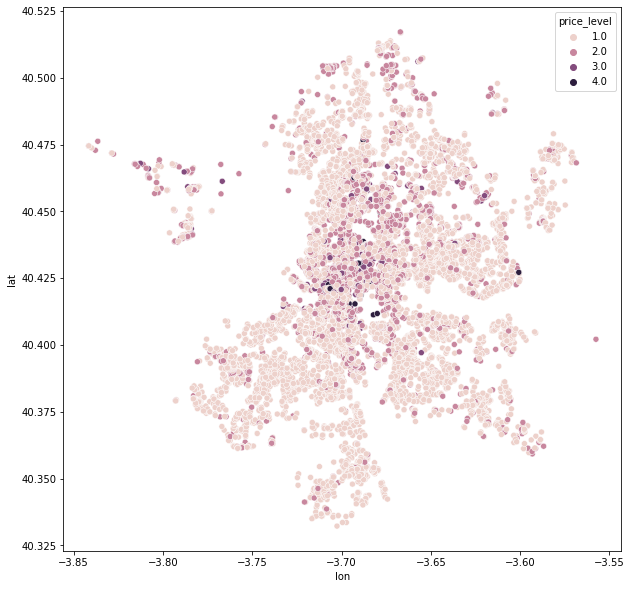

In [7]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='lon', y='lat', data=df_places_fe, hue='price_level')
plt.show()

Se define una nueva columna con pesos. Se observa en los datos que a mayor número de categoría menor es su representación en el dataset, en la ecuación definida para calcular los pesos se tiene en cuenta esta representación. De este modo, se da más valor a los puntos que pertenecen a una categoría menos representada (que en este caso es también la más valorada).

**IMPORTANTE**: Tener en cuenta que se estudiará una media x registros. Si uno de los pesos es mucho mayor a los demás, este puede afectar a la media y a la distribución de los datos de la nueva variable negativamente.

In [126]:
def weights(x, df):
    num = list(df.price_level.value_counts())
    denom = df.price_level.sum()
    eq = (1/(num[int(x)-1]/denom))**1
    eq_norm = eq/(1/(num[3]/denom))**1
    return eq_norm

In [127]:
# Se prueba definiendo una nueva columna con pesos 
df_places_fe["price_level_weights"] = df_places_fe["price_level"].apply(lambda x: weights(x, df_places_fe))

C:\Users\arni_\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [128]:
df_places_fe.head()

,place_id,rating,user_ratings_total,types,find_type,lat,lon,price_level_missing,price_level,price_level_weights,isInside
0,ChIJFxKKG7wnQg0RNYE_E60EZ7g,3.8,1348,"['restaurant', 'food', 'point_of_interest', 'e...",restaurant,40.386727,-3.718799,0,2.0,0.014450,True
1,ChIJo3OI7JYnQg0RGV2mWtE-9v8,4.0,220,"['restaurant', 'food', 'point_of_interest', 'e...",restaurant,40.385361,-3.726651,0,1.0,0.004242,False
2,ChIJwXyYMZEnQg0Rb9hEHqaxtO8,4.5,402,"['cafe', 'bar', 'restaurant', 'food', 'point_o...",restaurant,40.384738,-3.728618,0,1.0,0.004242,False
3,ChIJbYvKyL0nQg0R981bqgVos40,4.4,333,"['restaurant', 'cafe', 'bar', 'food', 'point_o...",restaurant,40.385918,-3.721233,0,1.0,0.004242,True
4,ChIJvz9205AnQg0RC21REfqPWeU,3.3,13,"['meal_delivery', 'restaurant', 'food', 'point...",restaurant,40.383741,-3.728431,1,1.0,0.004242,False


In [129]:
df_places_fe.price_level_weights.value_counts()

0.004242    8015
0.014450    2353
0.160377     212
1.000000      34
Name: price_level_weights, dtype: int64

## Agregación a los datos de Idealista

In [130]:
# Cargamos los datos de las viviendas de Idealista
df_idealista = pd.read_csv("Madrid_Idealista_Variable_Seleccionadas.csv")
df_idealista = df_idealista.drop(['Unnamed: 0'], axis = 1)
df_idealista.head()

,floor,price,propertyType,size,address,district,neighborhood,latitude,longitude,showAddress,hasParking,parkingIncludedInPrice,parkingPrice
0,bj,130000.0,flat,68.0,Calle De Silvio Abad,Usera,Zofío,40.379115,-3.714212,False,True,True,0.0
1,4,135000.0,flat,73.0,Calle de la Via,Carabanchel,Opañel,40.387897,-3.724639,False,False,False,0.0
2,1,95000.0,duplex,40.0,Calle Blasón,Carabanchel,Puerta Bonita,40.382783,-3.739771,False,False,False,0.0
3,1,114900.0,flat,51.0,Calle de Isabel Baeza,Carabanchel,Puerta Bonita,40.382663,-3.728994,False,False,False,0.0
4,3,134900.0,flat,64.0,Calle del Arroyo Opañel,Carabanchel,Opañel,40.389066,-3.721247,False,False,False,0.0


In [139]:
def isInside(circle_x, circle_y, x, y):
    """ Devuelve True si el punto está dentro del radio definido """
    rad = 1*60/6371 # Mejor Radio = 1000m o 1200m, corr con el precio de 0.55 (se ha probado rad = 800,1000,1200,1400)
    if ((x - circle_x)**2 + (y - circle_y)**2 <= rad**2):
        return True;
    else:
        return False;

def agregarFE(lon, lat):
    """ Devuelve la media de la variable price_level_weights de los puntos cercanos """
    df_places_fe["isInside"] = df_places_fe.apply(lambda x: isInside(lon, lat, x["lon"], x["lat"]), axis = 1)
    nearby_weights_mean = df_places_fe[df_places_fe["isInside"] == True].price_level_weights.mean()
    return nearby_weights_mean

In [141]:
df_idealista["places_weights"] = df_idealista.apply(lambda x: agregarFE(x["longitude"], x["latitude"]), axis = 1)

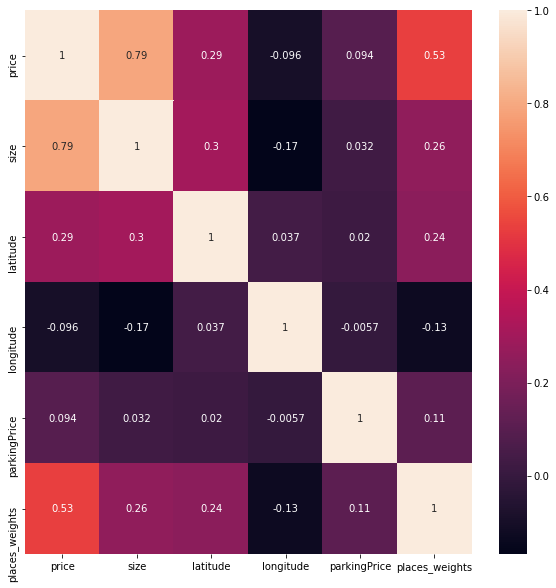

In [142]:
plt.figure(figsize=(10,10))
sns.heatmap(df_idealista.select_dtypes(include='number').corr(), annot=True)
plt.show()

In [144]:
df_idealista.head()

,floor,price,propertyType,size,address,district,neighborhood,latitude,longitude,showAddress,hasParking,parkingIncludedInPrice,parkingPrice,places_weights
0,bj,130000.0,flat,68.0,Calle De Silvio Abad,Usera,Zofío,40.379115,-3.714212,False,True,True,0.0,0.006720
1,4,135000.0,flat,73.0,Calle de la Via,Carabanchel,Opañel,40.387897,-3.724639,False,False,False,0.0,0.004738
2,1,95000.0,duplex,40.0,Calle Blasón,Carabanchel,Puerta Bonita,40.382783,-3.739771,False,False,False,0.0,0.004874
3,1,114900.0,flat,51.0,Calle de Isabel Baeza,Carabanchel,Puerta Bonita,40.382663,-3.728994,False,False,False,0.0,0.004642
4,3,134900.0,flat,64.0,Calle del Arroyo Opañel,Carabanchel,Opañel,40.389066,-3.721247,False,False,False,0.0,0.004849


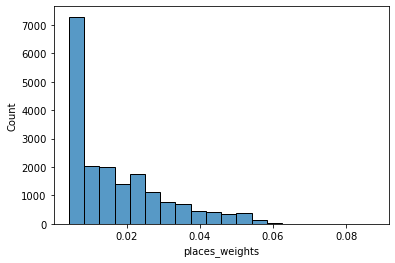

In [145]:
sns.histplot(x = "places_weights", data = df_idealista, bins = 20)
plt.show()

In [146]:
print("Media: ",df_idealista.places_weights.mean())
print("Mediana: ",df_idealista.places_weights.median())

Media:  0.01708595422356693
Mediana:  0.012828944616921387
